## Using Notebooks Server-side in Cat2Cloud

First install the latest versions of ``blosc2`` and ``caterva2`` 

In [1]:
# Install blosc2 and caterva2 in Pyodide environments
import sys
if sys.platform == "emscripten":
    # Install latest blosc2
    import requests
    import micropip
    url = "https://api.github.com/repos/Blosc/python-blosc2/releases/latest"
    resp = requests.get(url, headers={"Accept": "application/vnd.github+json"})
    latest_tag = resp.json()["tag_name"].strip('v')
    wheel_name=f"blosc2-{latest_tag}-cp312-cp312-pyodide_2024_0_wasm32.whl"
    wheel_url=f"https://blosc.github.io/python-blosc2/wheels/{wheel_name}"
    await micropip.install(wheel_url)
    print(f"Installed {wheel_name} successfully!")
    
    # Install latest Caterva2
    latest_url = "https://ironarray.github.io/Caterva2/wheels/latest.txt"
    # Fetch wheel name
    wheel_name = requests.get(latest_url).text.strip()
    # Install the wheel dynamically
    wheel_url = f"https://ironarray.github.io/Caterva2/wheels/{wheel_name}"
    await micropip.install(wheel_url)
    print(f"Installed {"Caterva2-main"} successfully!")

In [2]:
import caterva2 as cat2
import blosc2
import matplotlib.pyplot as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


Let's make an image

In [3]:
N = 200
root = "@shared"
auth_client = cat2.Client("https://cat2.cloud/demo", ("user@example.com", "foobar11"))

# build lazy expression and send to server to be computed
x = blosc2.lazyexpr(f"linspace(-1, 1, {N}, shape=({N}, 1))")
y = blosc2.lazyexpr("x.T")
r = .02
lexpr = blosc2.sin(blosc2.sqrt(x ** 2 + y ** 2) / r)
img_obj = auth_client.upload_lazyexpr('@shared/img.b2nd', expression=lexpr, compute=True)

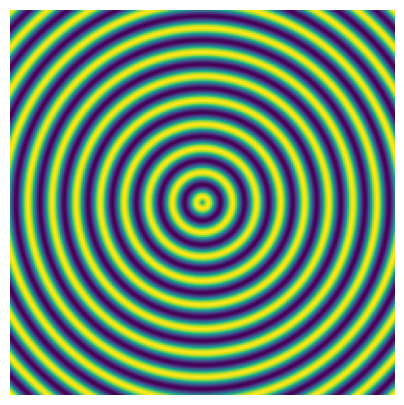

In [4]:
img = auth_client.fetch(img_obj)
fig = plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.gca().set_axis_off()

#### Blurring the image

In [5]:
# create blur matrix on disc
# --- Define blur kernel size ---
k = 4 # 9 x 9 kernel 
sig = 1
weights = np.exp(-np.arange(-k, k + 1) ** 2 / sig)
weights /= np.sum(weights)

# --- Build 1D blur matrix ---
B = np.zeros((N, N))
for i in range(N):
    for e, j in enumerate(range(max(0, i - k), min(N, i + k + 1))):
        B[i, j] = 1 / weights[e]
        
# compress to "disc"
localpath = '/tmp/B.b2nd'
B = blosc2.asarray(B, urlpath=localpath, mode='w')
# upload blur matrix
B_path = auth_client.upload(dataset='@shared/B.b2nd', localpath=localpath)

Now we need to apply the blur using a lazy expression, sent to the server.

In [6]:
B_path = '@shared/B.b2nd'
B = auth_client.get(B_path)
print(f'B is instance of {type(B)}, stored at {B}. Can be used in a lazy expression!')

# define expression which applies blur
blur_lexpr = blosc2.lazyexpr('matmul(matmul(B, img_obj), B.T)')
# upload lazy expression and compute server-side
blur_path = auth_client.upload_lazyexpr('@shared/blur_img.b2nd', expression=blur_lexpr, compute=True)

B is instance of <class 'caterva2.client.Dataset'>, stored at @shared/B.b2nd. Can be used in a lazy expression!


Ok, what does it look like now?

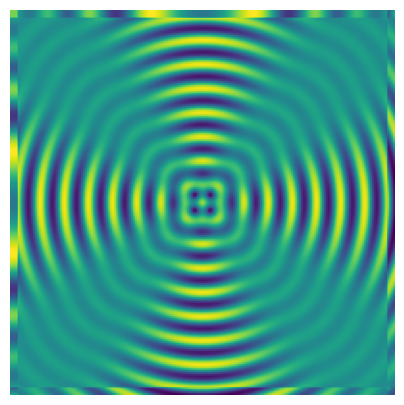

In [7]:
# fetch blurred image and plot
blur_img = auth_client.fetch(blur_path)
fig = plt.figure(figsize=(5, 5))
plt.imshow(blur_img)
plt.gca().set_axis_off()